In [246]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models

## Прописываем пути к данным

In [247]:
# Пути к данным
TRAIN_IMAGES_PATH = "Brain-tumor/train/images/"
TRAIN_LABELS_PATH = "Brain-tumor/train/labels/"
VALID_IMAGES_PATH = "Brain-tumor/valid/images/"
VALID_LABELS_PATH = "Brain-tumor/valid/labels/"

# Параметры модели
TARGET_SIZE = 224  # Размер изображения для модели
S = 7  # Размер сетки (S×S ячеек)
B = 2  # Количество bounding boxes на ячейку
C = 1  # Количество классов (только опухоль)

In [248]:
def letterbox(img, target=224):
    """
    Изменяет размер изображения с сохранением пропорций и добавляет черные поля.
    
    Аргументы:
        img: исходное изображение (numpy array)
        target: целевой размер (квадрат target×target)
    
    Возвращает:
        padded: обработанное изображение
        scale: коэффициент масштабирования
        left: отступ слева
        top: отступ сверху
    """
    h, w = img.shape[:2]
    
    # Проверка на пустое изображение
    if h == 0 or w == 0:
        raise ValueError("Пустое изображение с нулевым размером")
    
    # Вычисляем коэффициент масштабирования
    scale = target / max(h, w)
    new_w, new_h = int(w * scale), int(h * scale)
    
    # Изменяем размер с сохранением пропорций
    resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
    
    # Вычисляем размеры для добавления полей
    dw, dh = target - new_w, target - new_h
    left, right = dw // 2, dw - dw // 2
    top, bottom = dh // 2, dh - dh // 2
    
    # Добавляем черные поля
    padded = cv2.copyMakeBorder(resized, top, bottom, left, right,
                                cv2.BORDER_CONSTANT, value=(0, 0, 0))
    
    return padded, scale, left, top

## Обрабатываем изображения

In [249]:
class BrainTumorDataset(Dataset):
    """
    Датасет для детекции опухолей мозга в формате YOLO.
    
    Преобразует изображения и метки в формат, подходящий для обучения YOLO:
    - Изменяет размер изображений с сохранением пропорций (letterbox)
    - Преобразует bounding boxes в координаты относительно сетки S×S
    - Добавляет аугментацию (горизонтальный flip)
    """
    
    def __init__(self, root, S=7, target_size=224):
        """
        Аргументы:
            root: путь к папке с данными (должна содержать подпапки images/ и labels/)
            S: размер сетки (S×S ячеек)
            target_size: размер изображения для модели
        """
        self.root = root
        self.img_dir = os.path.join(root, "images")
        self.label_dir = os.path.join(root, "labels")
        
        # Проверка существования папок
        if not os.path.exists(self.img_dir) or not os.path.exists(self.label_dir):
            raise FileNotFoundError(f"Папки датасета не найдены в {root}: ожидаются 'images' и 'labels'")
        
        # Список файлов с метками
        self.files = sorted([f for f in os.listdir(self.label_dir) if f.endswith('.txt')])
        self.S = S
        self.target = target_size
    
    def __len__(self):
        """Возвращает количество примеров в датасете"""
        return len(self.files)
    
    def _find_image(self, base_name):
        """
        Ищет изображение по базовому имени (без расширения).
        Проверяет различные расширения изображений.
        """
        for ext in [".jpg", ".jpeg", ".png", ".bmp"]:
            p = os.path.join(self.img_dir, base_name + ext)
            if os.path.exists(p):
                return p
        return None
    
    def __getitem__(self, idx):
        """
        Загружает и обрабатывает один пример из датасета.
        
        Возвращает:
            img_tensor: тензор изображения [3, H, W], нормализованный [0, 1]
            target: целевой тензор для YOLO [S, S, B*5 + C]
        """
        # Загрузка меток
        label_file = self.files[idx]
        base = label_file[:-4]  # Имя файла без расширения
        img_path = self._find_image(base)
        
        if img_path is None:
            raise FileNotFoundError(f"Изображение для {base} не найдено в {self.img_dir}")
        
        label_path = os.path.join(self.label_dir, label_file)
        
        # Загрузка исходного изображения
        img = cv2.imread(img_path)
        if img is None:
            raise ValueError(f"Не удалось прочитать изображение {img_path}")
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h0, w0 = img.shape[:2]  # Оригинальные размеры
        
        # Предобработка изображения (letterbox)
        img_lb, scale, dx, dy = letterbox(img, self.target)
        
        # Загрузка и преобразование bounding boxes
        boxes = []  # Формат: [класс, cx_abs, cy_abs, w_abs, h_abs]
        
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) < 5:
                        continue
                    
                    # YOLO формат: класс x_center y_center width height (относительные координаты)
                    cls = int(float(parts[0]))
                    x = float(parts[1])
                    y = float(parts[2])
                    w = float(parts[3])
                    h = float(parts[4])
                    
                    # Конвертация в абсолютные координаты на исходном изображении
                    cx_orig = x * w0
                    cy_orig = y * h0
                    w_orig = w * w0
                    h_orig = h * h0
                    
                    # Применяем масштабирование и добавление полей
                    cx = cx_orig * scale + dx
                    cy = cy_orig * scale + dy
                    ww = w_orig * scale
                    hh = h_orig * scale
                    
                    boxes.append([cls, cx, cy, ww, hh])
        
        # Аугментация: горизонтальный flip с вероятностью 50%
        if random.random() < 0.5:
            img_lb = np.flip(img_lb, axis=1)  # Отражение по горизонтали
            for b in boxes:
                b[1] = self.target - b[1]  # Отражение координаты X центра
        
        # Построение целевого тензора для YOLO [S, S, B*5 + C]
        target = np.zeros((self.S, self.S, 11), dtype=np.float32)
        cell_size = self.target / self.S  # Размер одной ячейки в пикселях
        
        for cls, cx, cy, ww, hh in boxes:
            # Определение ячейки, содержащей центр объекта
            i = min(max(int(cy // cell_size), 0), self.S - 1)
            j = min(max(int(cx // cell_size), 0), self.S - 1)
            
            # Координаты относительно ячейки (нормализованные)
            x_cell = (cx - j * cell_size) / cell_size
            y_cell = (cy - i * cell_size) / cell_size
            
            # Нормализованные размеры относительно всего изображения
            w_norm = ww / self.target
            h_norm = hh / self.target
            
            # Заполнение первого bounding box
            target[i, j, 0:5] = np.array([x_cell, y_cell, w_norm, h_norm, 1.0], dtype=np.float32)
            # Заполнение второго bounding box (дублирование)
            target[i, j, 5:10] = np.array([x_cell, y_cell, w_norm, h_norm, 1.0], dtype=np.float32)
            # Признак наличия объекта в ячейке
            target[i, j, 10] = 1.0
        
        # Нормализация изображения и преобразование в тензор
        img_lb = img_lb.astype(np.float32) / 255.0
        img_lb = img_lb.transpose(2, 0, 1)  # Из [H, W, C] в [C, H, W]
        
        return torch.tensor(img_lb, dtype=torch.float32), torch.tensor(target, dtype=torch.float32)

## Задаем архитектуру модели

In [250]:
class MobileNetYOLO(nn.Module):
    """
    Модель YOLO на основе MobileNetV2.
    
    MobileNetV2 используется в качестве backbone для извлечения признаков,
    затем сверточный head предсказывает bounding boxes и confidence scores.
    """
    
    def __init__(self, S=7, B=2, C=1):
        """
        Аргументы:
            S: размер сетки (S×S ячеек)
            B: количество bounding boxes на ячейку
            C: количество классов
        """
        super().__init__()
        self.S, self.B, self.C = S, B, C
        
        # Backbone: предобученный MobileNetV2
        base = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
        self.backbone = base.features
        
        # Head для предсказания bounding boxes
        # Каждый bounding box: [x, y, w, h, confidence]
        # Всего выходных каналов: B*5 + C
        self.head = nn.Sequential(
            nn.Conv2d(1280, 512, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, B * 5 + C, 1)  # 2*5 + 1 = 11 каналов
        )
    
    def forward(self, x):
        """
        Прямой проход модели.
        
        Аргументы:
            x: входной тензор [batch, 3, H, W]
        
        Возвращает:
            Тензор [batch, S, S, B*5 + C]
        """
        # Извлечение признаков
        x = self.backbone(x)
        
        # Предсказание bounding boxes
        x = self.head(x)
        
        # Преобразование в формат [batch, S, S, channels]
        x = x.permute(0, 2, 3, 1)
        
        return x

## Задаем функцию потерь

In [251]:
class YOLOLoss(nn.Module):
    """
    Комбинированная функция потерь YOLO (YOLOv1 loss).
    
    Компоненты потерь:
    1. Потери по координатам (x, y, w, h) - только для ячеек с объектами
    2. Потери по уверенности (confidence) для объектов
    3. Потери по уверенности для фона
    4. Потери по классификации - только для ячеек с объектами
    """
    
    def __init__(self, S=7, B=2, C=1, lambda_coord=5.0, lambda_noobj=0.5):
        """
        Аргументы:
            S: размер сетки (S×S ячеек)
            B: количество bounding boxes на ячейку
            C: количество классов
            lambda_coord: вес для потерь по координатам
            lambda_noobj: вес для потерь по фону
        """
        super().__init__()
        self.S = S
        self.B = B
        self.C = C
        self.lambda_coord = lambda_coord
        self.lambda_noobj = lambda_noobj
        
        # Для стабильности вычислений
        self.eps = 1e-8
    
    def forward(self, pred, target):
        """
        Вычисление комбинированных потерь YOLO.
        
        Аргументы:
            pred: предсказания модели [batch, S, S, B*5 + C]
            target: целевые значения [batch, S, S, B*5 + C]
        
        Возвращает:
            Общие потери (scalar tensor)
        """
        batch_size = pred.size(0)
        
        # ============================================================
        # 1. ПОДГОТОВКА МАСОК
        # ============================================================
        
        # Маска для ячеек с объектами (confidence > 0)
        # В target[..., 4] хранится confidence первого bounding box
        obj_mask = target[..., 4] > 0.5  # Порог можно настроить
        noobj_mask = target[..., 4] == 0  # Ячейки без объектов
        
        # Преобразуем в float для умножения
        obj_mask_float = obj_mask.float()
        noobj_mask_float = noobj_mask.float()
        
        # ============================================================
        # 2. ПОТЕРИ ПО КООРДИНАТАМ (x, y, w, h)
        # ============================================================
        
        # Преобразуем предсказания и цели для удобства
        # pred shape: [batch, S, S, B*5 + C]
        # Разделяем на bounding boxes и классы
        pred_boxes = pred[..., :self.B*5].reshape(batch_size, self.S, self.S, self.B, 5)
        target_boxes = target[..., :self.B*5].reshape(batch_size, self.S, self.S, self.B, 5)
        
        # Для каждой ячейки выбираем bounding box с наибольшим IoU с ground truth
        # В простейшей реализации используем первый bounding box (как в оригинальном YOLO)
        pred_box = pred_boxes[..., 0, :]  # [batch, S, S, 5]
        target_box = target_boxes[..., 0, :]  # [batch, S, S, 5]
        
        # Потери по координатам центра (x, y) - MSE
        # Применяем только к ячейкам с объектами
        loss_xy = ((pred_box[..., 0:2] - target_box[..., 0:2]) ** 2)
        loss_xy = (loss_xy.sum(dim=-1) * obj_mask_float).sum()
        
        # Потери по размерам (w, h) - MSE с sqrt для стабильности
        # В оригинальном YOLO используется sqrt(w) и sqrt(h)
        pred_wh = torch.sqrt(pred_box[..., 2:4].clamp(min=self.eps))
        target_wh = torch.sqrt(target_box[..., 2:4].clamp(min=self.eps))
        loss_wh = ((pred_wh - target_wh) ** 2)
        loss_wh = (loss_wh.sum(dim=-1) * obj_mask_float).sum()
        
        # ============================================================
        # 3. ПОТЕРИ ПО УВЕРЕННОСТИ (CONFIDENCE)
        # ============================================================
        
        # Confidence для объектов
        pred_conf_obj = pred_box[..., 4]  # [batch, S, S]
        target_conf_obj = target_box[..., 4]  # [batch, S, S]
        loss_conf_obj = ((pred_conf_obj - target_conf_obj) ** 2 * obj_mask_float).sum()
        
        # Confidence для фона
        # Используем все bounding boxes для фона
        loss_conf_noobj = 0
        for b in range(self.B):
            pred_conf = pred_boxes[..., b, 4]  # [batch, S, S]
            target_conf = target_boxes[..., b, 4]  # [batch, S, S]
            loss_conf_noobj += ((pred_conf - target_conf) ** 2 * noobj_mask_float).sum()
        
        # ============================================================
        # 4. ПОТЕРИ ПО КЛАССИФИКАЦИИ
        # ============================================================
        
        # Извлекаем предсказания классов
        pred_class = pred[..., self.B*5:]  # [batch, S, S, C]
        target_class = target[..., self.B*5:]  # [batch, S, S, C]
        
        # Потери по классификации (MSE между вероятностями классов)
        # Применяем только к ячейкам с объектами
        loss_class = ((pred_class - target_class) ** 2)
        loss_class = (loss_class.sum(dim=-1) * obj_mask_float).sum()
        
        # ============================================================
        # 5. КОМБИНАЦИЯ ВСЕХ КОМПОНЕНТОВ
        # ============================================================
        
        # Итоговые потери с весами
        total_loss = (
            self.lambda_coord * (loss_xy + loss_wh) +  # Потери по координатам
            loss_conf_obj +                            # Confidence для объектов
            self.lambda_noobj * loss_conf_noobj +      # Confidence для фона  
            loss_class                                 # Потери классификации
        )
        
        # Нормализация по количеству объектов (опционально)
        num_obj = obj_mask_float.sum().clamp(min=1.0)
        total_loss = total_loss / num_obj
        
        return total_loss

In [252]:
def iou(box1, box2):
    """
    Вычисляет Intersection over Union (IoU) между двумя bounding boxes.
    
    Аргументы:
        box1, box2: bounding boxes в формате [cx, cy, w, h]
    
    Возвращает:
        IoU значение (float)
    """
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    
    # Конвертация из центра к углам
    xa1, ya1 = x1 - w1/2, y1 - h1/2
    xa2, ya2 = x1 + w1/2, y1 + h1/2
    xb1, yb1 = x2 - w2/2, y2 - h2/2
    xb2, yb2 = x2 + w2/2, y2 + h2/2
    
    # Вычисление площади пересечения
    inter_w = max(0.0, min(xa2, xb2) - max(xa1, xb1))
    inter_h = max(0.0, min(ya2, yb2) - max(ya1, yb1))
    inter = inter_w * inter_h
    
    # Площади каждого bounding box
    area1 = w1 * h1
    area2 = w2 * h2
    
    # IoU
    return inter / (area1 + area2 - inter + 1e-8)


def nms(boxes, scores, iou_thr=0.2, conf_threshold=0.3):
    """
    Стабильный Non-Maximum Suppression.
    
    Аргументы:
        boxes: массив bounding boxes [N, 4] в формате [cx, cy, w, h]
        scores: массив confidence scores [N]
        iou_thr: порог IoU для подавления
        conf_threshold: дополнительный порог confidence
    
    Возвращает:
        keep: индексы bounding boxes, которые нужно оставить
    """
    if len(boxes) == 0:
        return np.array([], dtype=int)
    
    # 1. Фильтрация по confidence threshold
    keep_conf = scores >= conf_threshold
    boxes = boxes[keep_conf]
    scores = scores[keep_conf]
    
    if len(boxes) == 0:
        return np.array([], dtype=int)
    
    # 2. Конвертация из центра+размер в x1,y1,x2,y2
    x1 = boxes[:, 0] - boxes[:, 2] / 2
    y1 = boxes[:, 1] - boxes[:, 3] / 2
    x2 = boxes[:, 0] + boxes[:, 2] / 2
    y2 = boxes[:, 1] + boxes[:, 3] / 2
    
    # 3. Вычисление площадей
    areas = (x2 - x1) * (y2 - y1)
    
    # 4. Сортировка индексов по убыванию confidence
    indices = np.argsort(scores)[::-1]
    
    keep = []
    
    while len(indices) > 0:
        # Берем индекс с наибольшим confidence
        current = indices[0]
        keep.append(current)
        
        if len(indices) == 1:
            break
        
        # Остальные bounding boxes
        rest = indices[1:]
        
        # Вычисление пересечения с остальными
        xx1 = np.maximum(x1[current], x1[rest])
        yy1 = np.maximum(y1[current], y1[rest])
        xx2 = np.minimum(x2[current], x2[rest])
        yy2 = np.minimum(y2[current], y2[rest])
        
        # Ширина и высота пересечения
        w = np.maximum(0.0, xx2 - xx1)
        h = np.maximum(0.0, yy2 - yy1)
        intersection = w * h
        
        # Вычисление IoU
        union = areas[current] + areas[rest] - intersection
        iou = intersection / (union + 1e-8)
        
        # Оставляем только те, у которых IoU <= порога
        indices = rest[iou <= iou_thr]
    
    return np.array(keep)


def decode_predictions(pred, conf_thr=0.5, S=7, target_size=224):
    """
    Декодирует выход модели YOLO в bounding boxes.
    
    Аргументы:
        pred: выход модели [S, S, B*5 + C]
        conf_thr: порог confidence для фильтрации
        S: размер сетки
        target_size: размер изображения
    
    Возвращает:
        boxes: bounding boxes в формате [cx, cy, w, h] (пиксели)
        scores: confidence scores
    """
    pred = pred.detach().cpu().numpy()
    boxes = []
    scores = []
    
    cell_size = target_size / S
    
    for i in range(S):        # строки
        for j in range(S):    # столбцы
            
            # Проверяем ОБА bounding boxes в каждой ячейке
            for b in range(2):  # B=2
                # Индекс confidence для текущего bounding box
                conf_idx = 4 + b * 5  # 4 для первого bbox, 9 для второго
                conf = pred[i, j, conf_idx]
                
                # Фильтрация по порогу confidence
                if conf < conf_thr:
                    continue
                
                # Извлекаем параметры текущего bounding box
                start_idx = b * 5
                x_cell, y_cell, w_norm, h_norm = pred[i, j, start_idx:start_idx+4]
                
                # Конвертация в абсолютные координаты
                # x_cell, y_cell в диапазоне [0, 1] относительно ячейки
                cx = (j + x_cell) * cell_size
                cy = (i + y_cell) * cell_size
                ww = w_norm * target_size
                hh = h_norm * target_size
                
                # Проверка на валидность координат
                if ww > 0 and hh > 0:
                    boxes.append([cx, cy, ww, hh])
                    scores.append(conf)
    
    return np.array(boxes), np.array(scores)

In [253]:
def calculate_iou(box1, box2):
    """
    Вычисление IoU для двух bounding boxes в формате [cx, cy, w, h]
    """
    # Конвертация в [x1, y1, x2, y2]
    x1_1, y1_1 = box1[0] - box1[2]/2, box1[1] - box1[3]/2
    x2_1, y2_1 = box1[0] + box1[2]/2, box1[1] + box1[3]/2
    
    x1_2, y1_2 = box2[0] - box2[2]/2, box2[1] - box2[3]/2
    x2_2, y2_2 = box2[0] + box2[2]/2, box2[1] + box2[3]/2
    
    # Площади
    area1 = box1[2] * box1[3]
    area2 = box2[2] * box2[3]
    
    # Координаты пересечения
    x1_inter = max(x1_1, x1_2)
    y1_inter = max(y1_1, y1_2)
    x2_inter = min(x2_1, x2_2)
    y2_inter = min(y2_1, y2_2)
    
    # Площадь пересечения
    inter_area = max(0, x2_inter - x1_inter) * max(0, y2_inter - y1_inter)
    
    # IoU
    iou = inter_area / (area1 + area2 - inter_area + 1e-6)
    
    return iou

In [254]:
def extract_ground_truth(target, S=7, target_size=224):
    """
    Извлекает ground truth bounding boxes из целевого тензора.
    
    Аргументы:
        target: целевой тензор [S, S, B*5 + C]
        S: размер сетки
        target_size: размер изображения
    
    Возвращает:
        Массив bounding boxes в формате [cx, cy, w, h]
    """
    t = target.detach().cpu().numpy()
    boxes = []
    cell_size = target_size / S
    
    for i in range(S):
        for j in range(S):
            # Проверяем наличие объекта в ячейке
            conf = t[i, j, 4]
            if conf > 0:  # объект присутствует
                x_cell, y_cell, w_norm, h_norm = t[i, j, 0:4]
                
                # Конвертация в абсолютные координаты
                cx = (j + x_cell) * cell_size
                cy = (i + y_cell) * cell_size
                ww = w_norm * target_size
                hh = h_norm * target_size
                
                boxes.append([cx, cy, ww, hh])
    
    return np.array(boxes)


def iou_np(box1, box2):
    """
    Вычисление IoU для numpy массивов.
    """
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    
    # Конвертация из центра к углам
    xa1, ya1 = x1 - w1/2, y1 - h1/2
    xa2, ya2 = x1 + w1/2, y1 + h1/2
    xb1, yb1 = x2 - w2/2, y2 - h2/2
    xb2, yb2 = x2 + w2/2, y2 + h2/2
    
    # Вычисление пересечения
    inter_x1 = max(xa1, xb1)
    inter_y1 = max(ya1, yb1)
    inter_x2 = min(xa2, xb2)
    inter_y2 = min(ya2, yb2)
    
    inter = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)
    area1 = w1 * h1
    area2 = w2 * h2
    
    return inter / (area1 + area2 - inter + 1e-6)


def evaluate_image(pred_boxes, gt_boxes, iou_thr=0.2):
    """
    Вычисление TP, FP, FN для одного изображения.
    """
    if len(gt_boxes) == 0:
        # Если объектов нет, все предсказания - FP
        return 0, len(pred_boxes), 0
    
    if len(pred_boxes) == 0:
        # Если предсказаний нет, все объекты - FN
        return 0, 0, len(gt_boxes)
    
    # Матрица IoU между всеми предсказаниями и ground truth
    iou_matrix = np.zeros((len(pred_boxes), len(gt_boxes)))
    for i, pred_box in enumerate(pred_boxes):
        for j, gt_box in enumerate(gt_boxes):
            iou_matrix[i, j] = calculate_iou(pred_box, gt_box)
    
    # Сопоставление: каждый ground truth может быть сопоставлен только с одним предсказанием
    matched_gt = np.zeros(len(gt_boxes), dtype=bool)
    matched_pred = np.zeros(len(pred_boxes), dtype=bool)
    
    # Сначала сопоставляем наилучшие совпадения
    for _ in range(min(len(pred_boxes), len(gt_boxes))):
        max_iou = np.max(iou_matrix)
        if max_iou < iou_thr:
            break
            
        pred_idx, gt_idx = np.unravel_index(np.argmax(iou_matrix), iou_matrix.shape)
        
        matched_gt[gt_idx] = True
        matched_pred[pred_idx] = True
        
        # Обнуляем строку и столбец
        iou_matrix[pred_idx, :] = 0
        iou_matrix[:, gt_idx] = 0
    
    tp = np.sum(matched_gt)
    fp = len(pred_boxes) - np.sum(matched_pred)
    fn = len(gt_boxes) - tp
    
    return tp, fp, fn

In [255]:
def visualize_predictions(model, dataset, device, n_images=20, S=7, target_size=224, conf_thr=0.4):
    """
    Визуализирует предсказания модели на случайных изображениях.
    Только для качественного анализа, без подсчета метрик.
    """
    model.eval()
    
    # Случайный выбор изображений
    idxs = np.random.choice(len(dataset), size=min(n_images, len(dataset)), replace=False)
    
    # Настройка размера фигуры
    n_cols = 5
    n_rows = int(np.ceil(n_images / n_cols))
    plt.figure(figsize=(n_cols * 4, n_rows * 4))
    
    for k, idx in enumerate(idxs):
        # Загрузка данных
        img_tensor, target_tensor = dataset[idx]
        
        # Предсказание модели
        x = img_tensor.unsqueeze(0).to(device)
        pred = model(x)[0]
        
        # Декодирование предсказаний
        pred_boxes, pred_scores = decode_predictions(pred, conf_thr=conf_thr, S=S, target_size=target_size)
        
        # Применение Non-Maximum Suppression - ИСПРАВЛЕНИЕ ЗДЕСЬ
        if len(pred_boxes) > 0:
            keep = nms(pred_boxes, pred_scores, iou_thr=0.5)  # ← исправлено: iou_thr вместо iou_th
            pred_boxes = pred_boxes[keep]
            pred_scores = pred_scores[keep]
        
        # Извлечение ground truth
        gt_boxes = extract_ground_truth(target_tensor, S=S, target_size=target_size)
        
        # Подготовка изображения для отображения
        img_np = img_tensor.numpy().transpose(1, 2, 0)
        img_np = (img_np * 255).astype(np.uint8)
        fig_img = img_np.copy()
        
        # Рисование ground truth bounding boxes (синие)
        for cx, cy, w, h in gt_boxes:
            x1, y1 = int(cx - w/2), int(cy - h/2)
            x2, y2 = int(cx + w/2), int(cy + h/2)
            cv2.rectangle(fig_img, (x1, y1), (x2, y2), (255, 0, 0), 2)
        
        # Рисование предсказанных bounding boxes (зеленые)
        for (cx, cy, w, h), conf in zip(pred_boxes, pred_scores):
            x1, y1 = int(cx - w/2), int(cy - h/2)
            x2, y2 = int(cx + w/2), int(cy + h/2)
            cv2.rectangle(fig_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            
            # Добавление confidence score
            cv2.putText(fig_img, f"{conf:.2f}", (x1, y1 - 5), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
        
        # Отображение
        plt.subplot(n_rows, n_cols, k + 1)
        plt.imshow(fig_img[..., ::-1])
        plt.axis('off')
        plt.title(f"Image {idx}")
    
    plt.tight_layout()
    plt.show()
    print(f"Визуализация {n_images} случайных изображений завершена")

In [256]:
def evaluate_model(model, dataloader, device, conf_thr=0.25, iou_thr=0.2, S=7, target_size=224):
    """
    Полная оценка модели на всем датасете.
    
    Возвращает:
        metrics: словарь с метриками (mAP, Precision, Recall, F1)
        predictions: список всех предсказаний для дальнейшего анализа
    """
    model.eval()
    
    # Для вычисления mAP
    all_predictions = []  # [(boxes, scores), ...]
    all_targets = []      # [boxes, ...]
    
    # Для простых метрик
    total_tp, total_fp, total_fn = 0, 0, 0
    
    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(dataloader):
            images = images.to(device)
            predictions = model(images)
            
            for i in range(len(images)):
                # Получаем предсказание для одного изображения
                pred = predictions[i]
                target = targets[i]
                
                # Декодирование предсказаний
                pred_boxes, pred_scores = decode_predictions(
                    pred, conf_thr=conf_thr, S=S, target_size=target_size
                )
                
                # NMS - ИСПРАВЛЕНИЕ ЗДЕСЬ
                if len(pred_boxes) > 0:
                    keep = nms(pred_boxes, pred_scores, iou_thr=0.5)  # ← исправлено: iou_thr вместо iou_th
                    pred_boxes = pred_boxes[keep]
                    pred_scores = pred_scores[keep]
                
                # Извлечение ground truth
                gt_boxes = extract_ground_truth(target, S=S, target_size=target_size)
                
                # Сохраняем для mAP
                all_predictions.append((pred_boxes, pred_scores))
                all_targets.append(gt_boxes)
                
                # Вычисляем TP, FP, FN для простых метрик
                tp, fp, fn = evaluate_image(pred_boxes, gt_boxes, iou_thr=iou_thr)
                total_tp += tp
                total_fp += fp
                total_fn += fn
            
            if batch_idx % 10 == 0:
                print(f"Обработано батчей: {batch_idx+1}/{len(dataloader)}")
    
    # Вычисление простых метрик
    precision = total_tp / (total_tp + total_fp + 1e-6)
    recall = total_tp / (total_tp + total_fn + 1e-6)
    f1 = 2 * precision * recall / (precision + recall + 1e-6)
    
    # Вычисление mAP
    print("\nВычисление mAP...")
    map_score, ap_results = calculate_map(all_predictions, all_targets)
    
    # Сбор всех метрик
    metrics = {
        'mAP': map_score,
        'mAP_50': ap_results.get('AP@0.50', 0),
        'mAP_75': ap_results.get('AP@0.75', 0),
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'tp': total_tp,
        'fp': total_fp,
        'fn': total_fn,
        'total_images': len(all_predictions)
    }
    
    return metrics, all_predictions, all_targets


def calculate_map(predictions, targets, iou_thresholds=None):
    """
    Вычисление mAP по стандартному алгоритму.
    
    Args:
        predictions: список предсказаний [(boxes, scores), ...]
        targets: список ground truth [boxes, ...]
        iou_thresholds: пороги IoU для вычисления AP
    
    Returns:
        mAP: среднее AP по всем порогам
        ap_results: AP для каждого порога
    """
    if iou_thresholds is None:
        iou_thresholds = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
    
    # Вычисляем AP для каждого порога
    aps = []
    ap_results = {}
    
    for iou_thr in iou_thresholds:
        ap = calculate_average_precision(predictions, targets, iou_thr)
        aps.append(ap)
        ap_results[f'AP@{iou_thr:.2f}'] = ap
    
    # mAP = среднее AP по всем порогам
    map_score = np.mean(aps)
    
    return map_score, ap_results


def calculate_average_precision(predictions, targets, iou_thr=0.2):
    """
    Вычисление Average Precision для одного порога IoU.
    """
    all_detections = []
    
    # Собираем все детекции с уверенностью и флагом совпадения
    for idx, (pred_boxes, pred_scores) in enumerate(predictions):
        gt_boxes = targets[idx]
        
        # Сопоставление предсказаний с ground truth
        matched = np.zeros(len(gt_boxes), dtype=bool)
        
        # Сортируем предсказания по confidence
        sorted_indices = np.argsort(pred_scores)[::-1]
        
        for pred_idx in sorted_indices:
            box = pred_boxes[pred_idx]
            score = pred_scores[pred_idx]
            
            # Находим лучшее совпадение с ground truth
            best_iou = 0
            best_gt_idx = -1
            
            for gt_idx, gt_box in enumerate(gt_boxes):
                if matched[gt_idx]:
                    continue
                
                iou = calculate_iou(box, gt_box)
                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = gt_idx
            
            # Определяем TP/FP
            is_tp = best_iou >= iou_thr
            
            all_detections.append({
                'score': score,
                'is_tp': is_tp
            })
            
            if is_tp and best_gt_idx != -1:
                matched[best_gt_idx] = True
    
    # Сортируем все детекции по confidence
    all_detections.sort(key=lambda x: x['score'], reverse=True)
    
    # Вычисляем Precision-Recall кривую
    tp_cumsum = 0
    fp_cumsum = 0
    total_gt = sum(len(gt) for gt in targets)
    
    precisions = []
    recalls = []
    
    for det in all_detections:
        if det['is_tp']:
            tp_cumsum += 1
        else:
            fp_cumsum += 1
        
        precision = tp_cumsum / (tp_cumsum + fp_cumsum + 1e-6)
        recall = tp_cumsum / (total_gt + 1e-6)
        
        precisions.append(precision)
        recalls.append(recall)
    
    # Вычисляем AP (площадь под P-R кривой)
    if not precisions:
        return 0.0
    
    # 11-point interpolation (стандарт Pascal VOC)
    recall_levels = np.linspace(0, 1, 11)
    interp_precisions = []
    
    for r in recall_levels:
        # Находим максимальную precision для recall >= r
        mask = np.array(recalls) >= r
        if mask.any():
            interp_precisions.append(np.max(np.array(precisions)[mask]))
        else:
            interp_precisions.append(0)
    
    ap = np.mean(interp_precisions)
    return ap

## Функция обучения

In [257]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    """
    Один эпох обучения модели.
    
    Аргументы:
        model: модель для обучения
        loader: DataLoader с тренировочными данными
        criterion: функция потерь
        optimizer: оптимизатор
        device: устройство (cpu или cuda)
    
    Возвращает:
        Среднее значение потерь за эпоху
    """
    model.train()
    total_loss = 0.0
    n_batches = 0
    
    for batch_idx, (x, y) in enumerate(loader):
        # Перемещение данных на устройство
        x, y = x.to(device), y.to(device)
        
        # Прямой проход
        pred = model(x)
        loss = criterion(pred, y)
        
        # Обратный проход и оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Накопление статистики
        total_loss += loss.item()
        n_batches += 1
        
        # Логирование каждые 10 батчей
        if batch_idx % 10 == 0:
            print(f"  Batch {batch_idx}/{len(loader)}, Loss: {loss.item():.4f}")
    
    return total_loss / n_batches if n_batches > 0 else 0.0

## Основной пайплайн: загрузка данных, обучение модели, оценка результатов.

ЗАГРУЗКА ДАННЫХ
Используется устройство: cuda
Тренировочный датасет: 878 изображений
Валидационный датасет: 223 изображений

СОЗДАНИЕ МОДЕЛИ
Модель создана: MobileNetYOLO с параметрами S=7, B=2, C=1
Всего параметров: 8,128,267

ОБУЧЕНИЕ МОДЕЛИ

Эпоха 1/100
  Batch 0/110, Loss: 7.8637
  Batch 10/110, Loss: 4.0520
  Batch 20/110, Loss: 3.6959
  Batch 30/110, Loss: 2.2905
  Batch 40/110, Loss: 2.7256
  Batch 50/110, Loss: 2.0314
  Batch 60/110, Loss: 2.3259
  Batch 70/110, Loss: 2.3449
  Batch 80/110, Loss: 2.3680
  Batch 90/110, Loss: 1.8331
  Batch 100/110, Loss: 1.7807
Средние потери за эпоху: 2.7366

Эпоха 2/100
  Batch 0/110, Loss: 1.6885
  Batch 10/110, Loss: 1.4232
  Batch 20/110, Loss: 1.6385
  Batch 30/110, Loss: 1.5516
  Batch 40/110, Loss: 1.7020
  Batch 50/110, Loss: 1.8348
  Batch 60/110, Loss: 1.3058
  Batch 70/110, Loss: 1.5579
  Batch 80/110, Loss: 1.7586
  Batch 90/110, Loss: 1.0913
  Batch 100/110, Loss: 1.5457
Средние потери за эпоху: 1.4984

Эпоха 3/100
  Batch 0/110, 

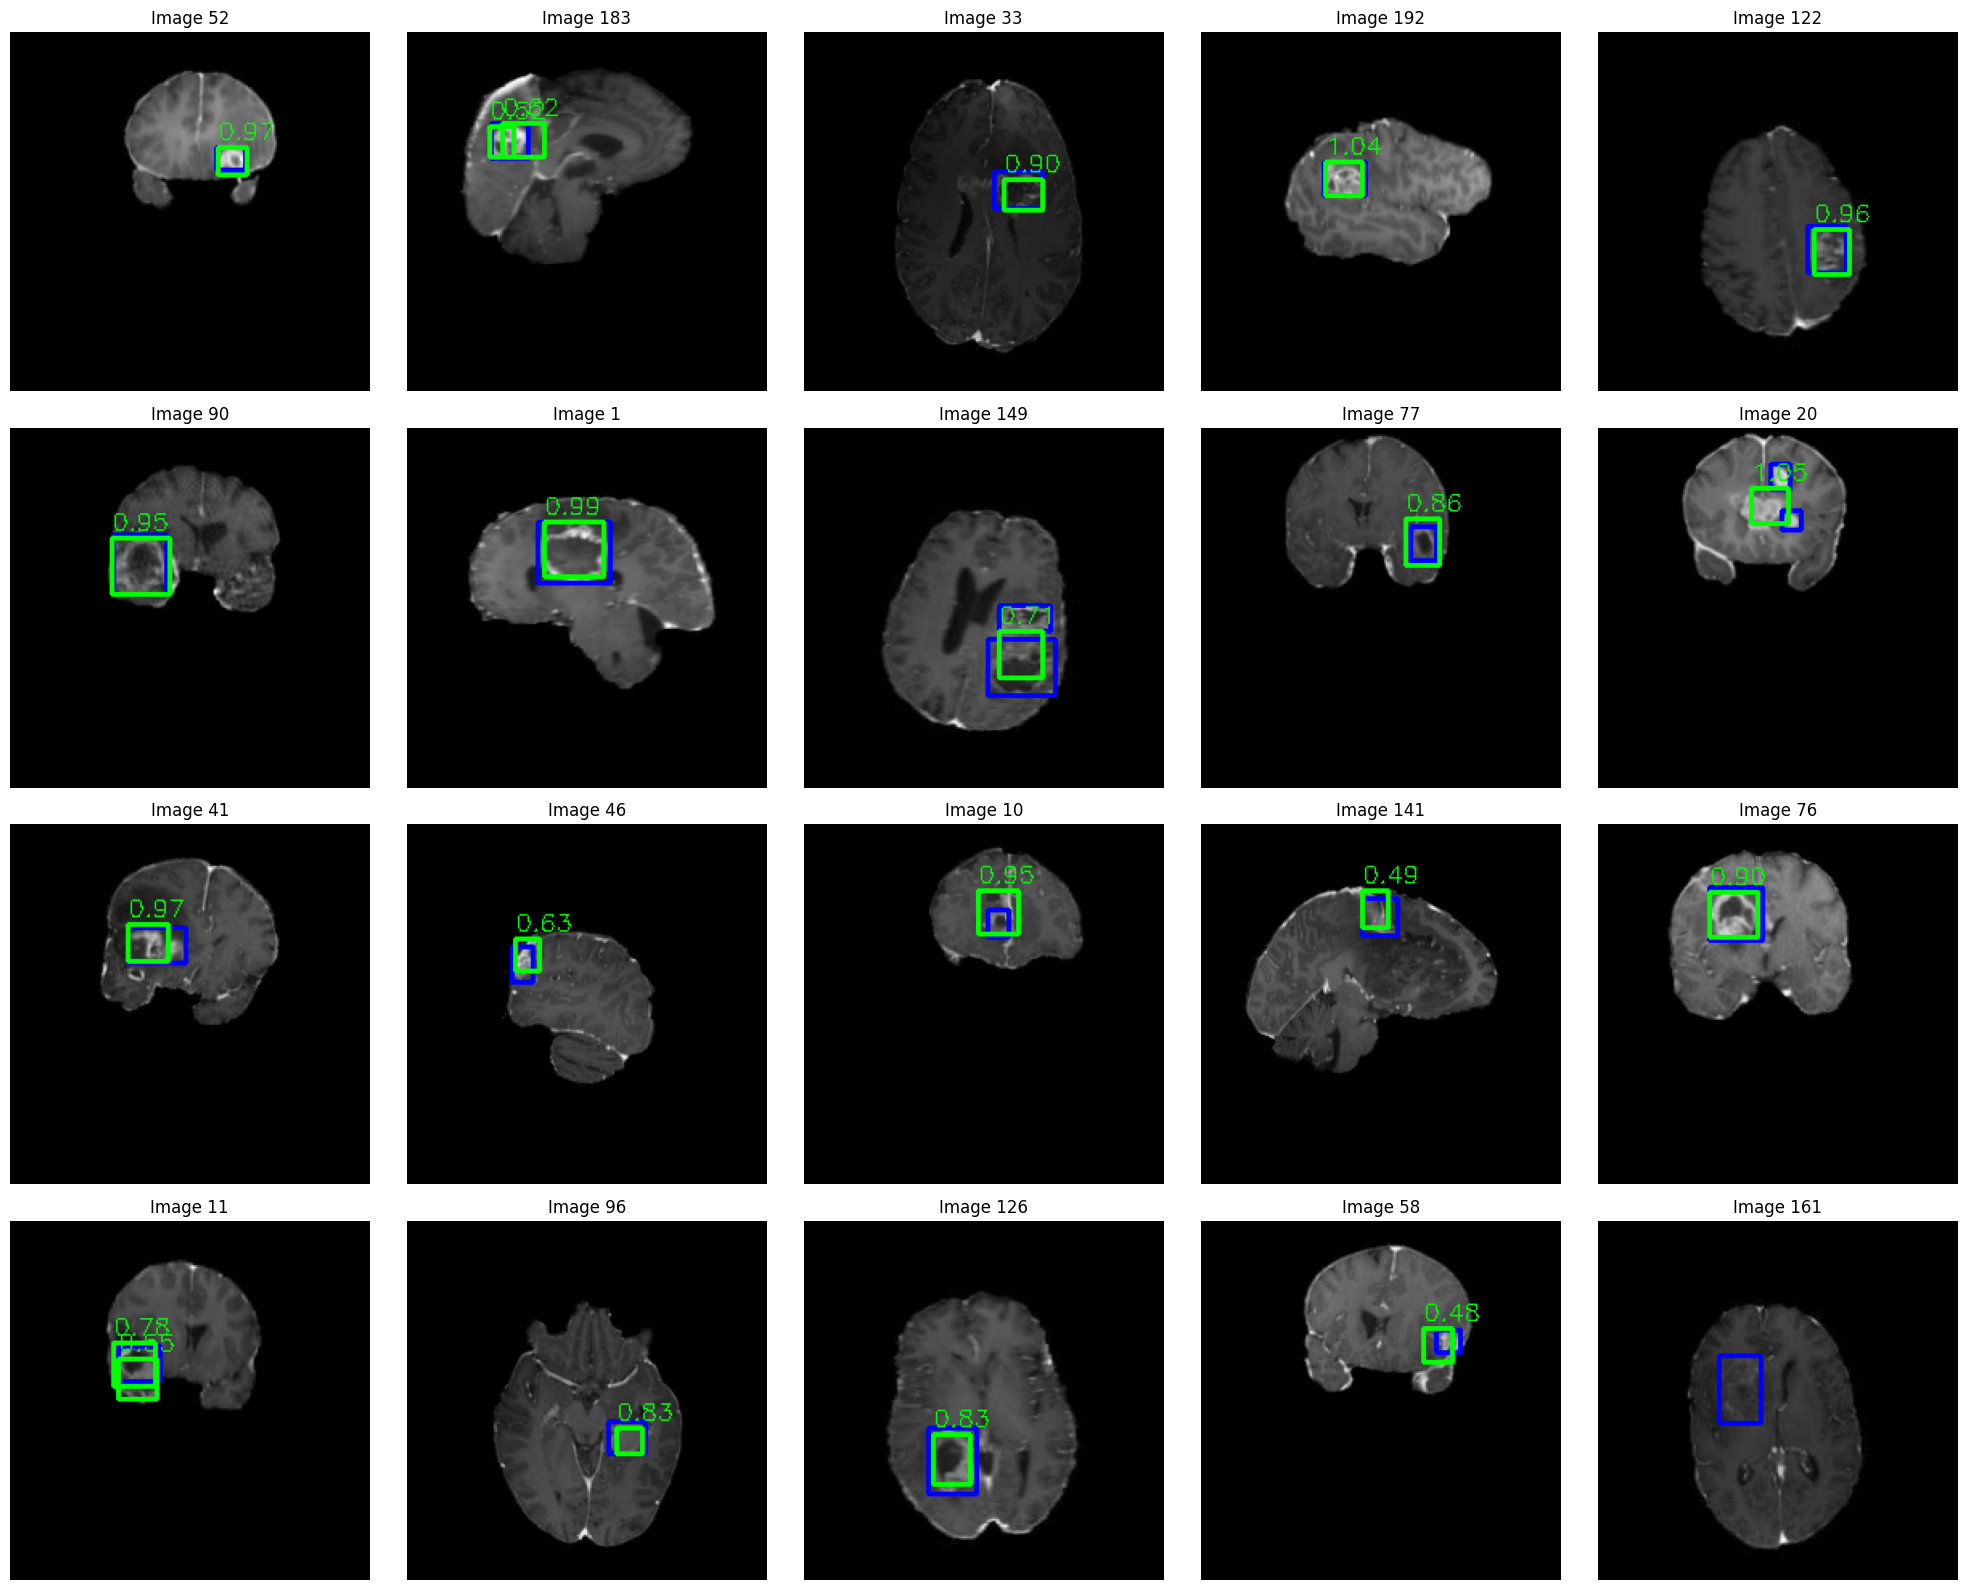

Визуализация 20 случайных изображений завершена

Полная оценка на всей валидации:
Обработано батчей: 1/28
Обработано батчей: 11/28
Обработано батчей: 21/28

Вычисление mAP...

 Результаты оценки модели:
Общее количество изображений: 223
mAP: 0.1243
mAP@0.50: 0.3949
mAP@0.75: 0.0606
Precision: 0.8072
Recall: 0.8517
F1-Score: 0.8289
TP: 201, FP: 48, FN: 35


In [258]:
print("=" * 60)
print("ЗАГРУЗКА ДАННЫХ")
print("=" * 60)

# Проверка доступности GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Используется устройство: {device}")

# Создание датасетов и DataLoader'ов
train_ds = BrainTumorDataset(os.path.join("Brain-tumor", "train"), 
                            S=S, target_size=TARGET_SIZE)
val_ds = BrainTumorDataset(os.path.join("Brain-tumor", "valid"),  # ← Изменение названия
                            S=S, target_size=TARGET_SIZE)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, 
                            num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False,  # ← Изменение названия
                        num_workers=2, pin_memory=True)

print(f"Тренировочный датасет: {len(train_ds)} изображений")
print(f"Валидационный датасет: {len(val_ds)} изображений")
    

print("\n" + "=" * 60)
print("СОЗДАНИЕ МОДЕЛИ")
print("=" * 60)

# Инициализация модели, функции потерь и оптимизатора
model = MobileNetYOLO(S=S, B=B, C=C).to(device)
criterion = YOLOLoss(S=S, B=B, C=C)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

print(f"Модель создана: MobileNetYOLO с параметрами S={S}, B={B}, C={C}")
print(f"Всего параметров: {sum(p.numel() for p in model.parameters()):,}")

print("\n" + "=" * 60)
print("ОБУЧЕНИЕ МОДЕЛИ")
print("=" * 60)

# Обучение модели
num_epochs = 100
for epoch in range(num_epochs):
    print(f"\nЭпоха {epoch + 1}/{num_epochs}")
    
    # Обучение на тренировочных данных
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    print(f"Средние потери за эпоху: {train_loss:.4f}")

# Сохранение модели
torch.save(model.state_dict(), "yolo_mobilenet_brain_tumor.pt")
print(f"\nМодель сохранена в 'yolo_mobilenet_brain_tumor.pt'")

print("\n" + "=" * 60)
print("ВИЗУАЛИЗАЦИЯ И ОЦЕНКА")
print("=" * 60)

# Визуализация случайных изображений (используем val_ds вместо val_dataset)
visualize_predictions(model, val_ds, device, n_images=20)  # ← Используем val_ds

print("\n" + "="*50)
print("Полная оценка на всей валидации:")
print("="*50)

# Полная оценка на всем валидационном датасете (используем val_loader вместо val_dataloader)
metrics, all_preds, all_targets = evaluate_model(
    model, val_loader, device,  # ← Используем val_loader
    conf_thr=0.25,
    iou_thr=0.2
)

print("\n Результаты оценки модели:")
print(f"Общее количество изображений: {metrics['total_images']}")
print(f"mAP: {metrics['mAP']:.4f}")
print(f"mAP@0.50: {metrics['mAP_50']:.4f}")
print(f"mAP@0.75: {metrics['mAP_75']:.4f}")
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall: {metrics['recall']:.4f}")
print(f"F1-Score: {metrics['f1']:.4f}")
print(f"TP: {metrics['tp']}, FP: {metrics['fp']}, FN: {metrics['fn']}")
